In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [41]:
df = pd.read_csv('Mumbai House Prices.csv')

In [43]:
df.head()

,bhk,type,locality,area,price,price_unit,region,status,age
0,3,Apartment,Lak And Hanware The Residency Tower,685,2.50,Cr,Andheri West,Ready to move,New
1,2,Apartment,Radheya Sai Enclave Building No 2,640,52.51,L,Naigaon East,Under Construction,New
2,2,Apartment,Romell Serene,610,1.73,Cr,Borivali West,Under Construction,New
3,2,Apartment,Soundlines Codename Urban Rainforest,876,59.98,L,Panvel,Under Construction,New
4,2,Apartment,Origin Oriana,659,94.11,L,Mira Road East,Under Construction,New


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76038 entries, 0 to 76037
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bhk              76038 non-null  int64  
 1   type             76038 non-null  object 
 2   locality         76038 non-null  object 
 3   area             76038 non-null  int64  
 4   region           76038 non-null  object 
 5   status           76038 non-null  object 
 6   age              76038 non-null  object 
 7   price_in_rupees  76038 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 4.6+ MB


In [45]:
def price_final(price, price_unit):
    if price_unit == 'L':
        return (price * 100000) / 1e7
    elif price_unit == 'Cr':
        return (price * 10000000) / 1e7
    else:
        return price


In [47]:
df['price_in_rupees'] = df.apply(lambda row: price_final(row['price'], row['price_unit']), axis=1)
df.drop(columns=['price', 'price_unit'], inplace=True)

In [49]:
df.head()

,bhk,type,locality,area,region,status,age,price_in_rupees
0,3,Apartment,Lak And Hanware The Residency Tower,685,Andheri West,Ready to move,New,2.5000
1,2,Apartment,Radheya Sai Enclave Building No 2,640,Naigaon East,Under Construction,New,0.5251
2,2,Apartment,Romell Serene,610,Borivali West,Under Construction,New,1.7300
3,2,Apartment,Soundlines Codename Urban Rainforest,876,Panvel,Under Construction,New,0.5998
4,2,Apartment,Origin Oriana,659,Mira Road East,Under Construction,New,0.9411


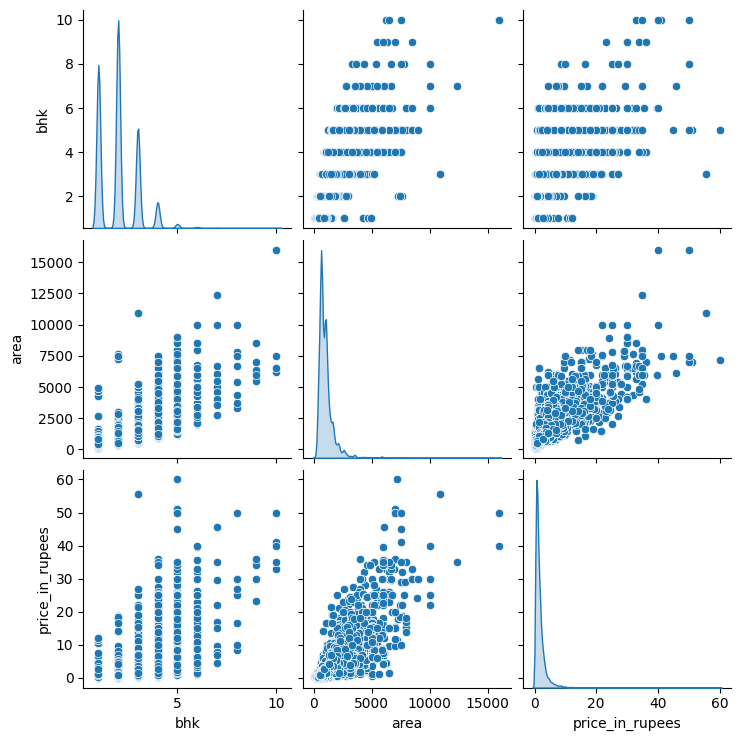

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Only use numeric columns for clean output
sns.pairplot(df[['bhk', 'area', 'price_in_rupees']], diag_kind="kde")
plt.show()


In [15]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score

#Why XGB regressor
# XGBRegressor is a powerful and efficient gradient boosting algorithm that often outperforms other models on structured/tabular data.

In [17]:
X = df.iloc[:, :-1]
y = df['price_in_rupees']

In [31]:
# 1. Split first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for feature in category_feature:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])


In [33]:
model = XGBRegressor()
model.fit(x_train, y_train)
predictions = model.predict(x_test)

In [35]:
r2 = r2_score(y_test, predictions)
print(f"R2 Score: {r2:.2f}")

R2 Score: 0.91


In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

print(f"RMSE: {rmse:.2f} Cr")
print(f"MAE: {mae:.2f} Cr")

RMSE: 0.65 Cr
MAE: 0.26 Cr


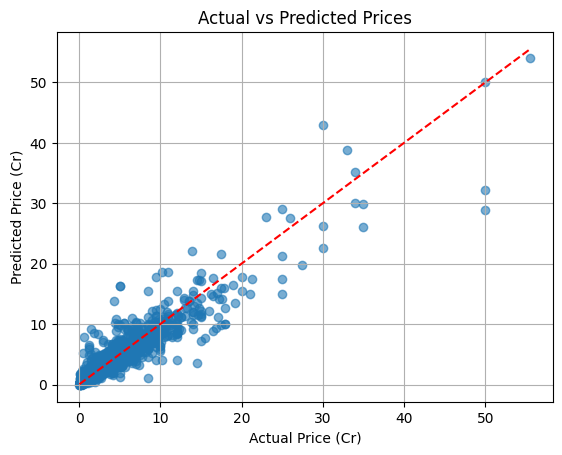

In [39]:
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price (Cr)")
plt.ylabel("Predicted Price (Cr)")
plt.title("Actual vs Predicted Prices")
plt.grid(True)
plt.show()

In [65]:
import joblib
joblib.dump(model, 'mumbai_house_price_model.pkl')

['mumbai_house_price_model.pkl']

In [1]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
